Treat image ROI takes electron diffraction patterns and calibrate the image, rotate it, draw the BZ around the Bragg peak and average equivalent BZ together

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1 import make_axes_locatable
import imutils
import glob
import matplotlib.ticker as ticker
import cv2  # importing cv
from skimage import img_as_float
from skimage import filters
import functions_analysis as fa
import find_peak

### All folder should countain a folder named 'data' containing pickle files ###

scan_number = '800nm'
path =r'C:\Users\rclaude\Documents\projet\graphite\data_UED\RAW_sorted'

t0_num = 8 #start from one

Zorder_in = np.array([242,247]) # guess position 0th order
BP1 = np.array([147,234]) # guess position 1st order Bragg peak

df = 0
file_list = (glob.glob(path + '/RAW_' + scan_number + '*.pickle'))
print('list of detected files : ', file_list)
imgON = []
imgOFF = []
for file in file_list: 
    input_df = pd.read_pickle(file, compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})
    imgON.append(np.stack(input_df['imagesON']))
    imgOFF.append(np.stack(input_df['imagesOFF']))

imgON_raw = np.sum(np.array(imgON), axis=0)
imgOFF_raw = np.sum(np.array(imgOFF), axis=0)
imgON = np.copy(imgON_raw)
imgOFF = np.copy(imgOFF_raw)
print('shape of image : ', imgON.shape)

df1 = input_df.drop('imagesON', axis=1)
df1 = input_df.drop('imagesOFF', axis=1)
delay= (df1['LTS_position'].to_numpy())
delay = (delay-delay[t0_num-1])*6.666
n_delay = len(delay)
print('delay array : ', delay)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
list of detected files :  ['C:\\Users\\rclaude\\Documents\\projet\\graphite\\data_UED\\RAW_sorted\\RAW_800nm.pickle']
shape of image :  (32, 512, 512)
delay array :  [-2.39976 -1.73316 -1.39986 -1.06656 -0.79992 -0.53328 -0.26664  0.
  0.26664  0.53328  0.79992  1.06656  1.3332   1.59984  1.86648  2.13312
  2.39976  2.6664   2.93304  3.19968  3.46632  3.73296  3.9996   4.6662
  5.3328   5.9994   6.666    7.3326   7.9992   8.26584  8.6658   8.93244]


Get rid of the hot pixel : set them with OFF pixels value

(32, 512, 512)
average ratio of hot pixel :  2.987813949584961
2.987813949584961


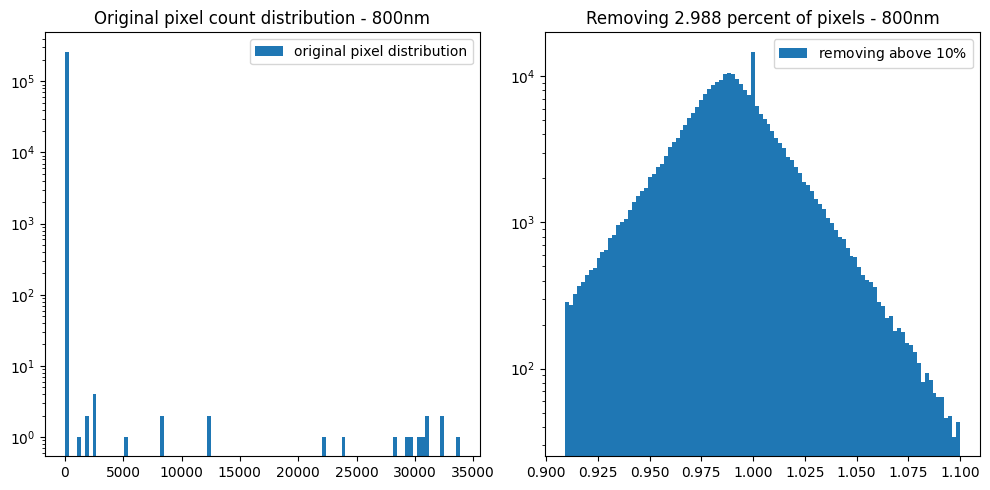

In [4]:
fig, axis = plt.subplots(1,2, figsize=(10,5), layout='tight')


imgON, imgOFF, rh = fa.remove_hot(imgON, imgOFF, 1.1)
print(rh)
axis[0].hist(((imgON_raw/imgOFF_raw)[0]).flatten(), bins=100, label=r'original pixel distribution')
axis[0].set_yscale('log')
axis[0].legend()
axis[0].set_title(r'Original pixel count distribution - ' + scan_number)

axis[1].hist(((imgON/imgOFF)[0]).flatten(), bins=100, label=r'removing above $10\%$')
axis[1].set_yscale('log')
axis[1].legend()
axis[1].set_title(r'Removing %.3f percent of pixels - '%rh + scan_number)

plt.savefig(path+r'\pixel_distribution.png', dpi=200)

Get the accurate position of unscattered beam with 2D pseudo-voigt fit 

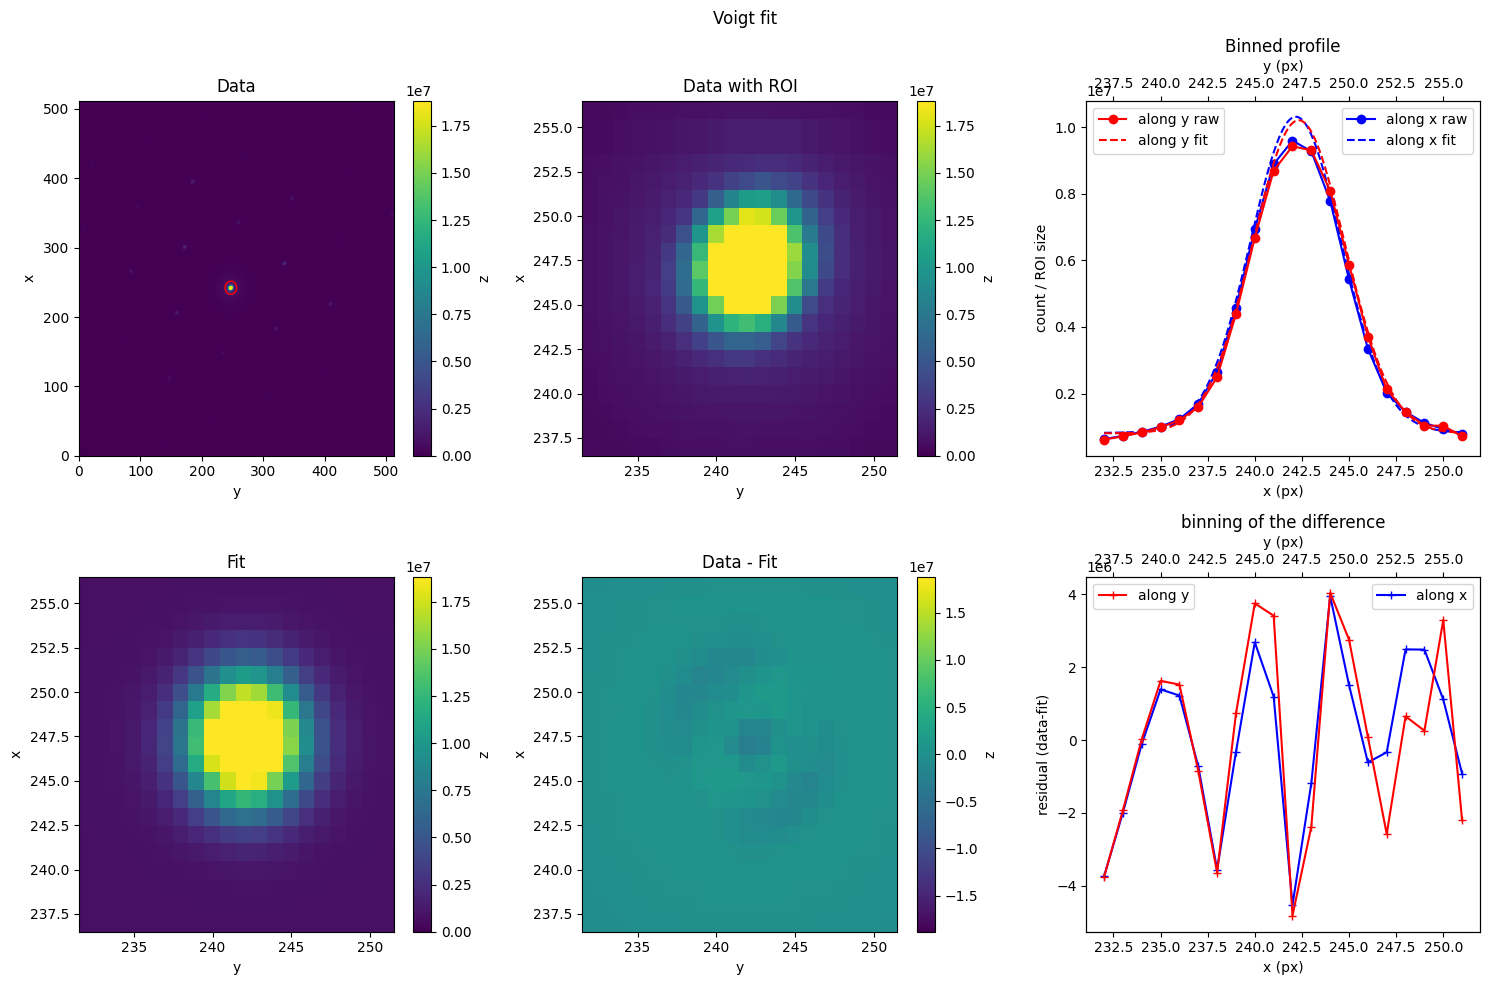

[242.17646721 247.32934423]
[242 247]


In [5]:
s_roi = 10
# Zorder_fit = find_peak.get_all(imgON[0], [Zorder_in[1]-s_roi, Zorder_in[1]+s_roi, Zorder_in[0]-s_roi, Zorder_in[0]+s_roi])[4:6]
Zorder_fit = find_peak.get_pos_around(imgON[0], Zorder_in, s_roi, method='2D_voigt', show_plot=True)
print(Zorder_fit)
## Zorder is the the position of the unscattered beam for delay = 0 
Zorder = np.reshape(Zorder_fit, (2,))
Zorder_in = Zorder.astype(np.int16)
print(Zorder_in)
vec_i = Zorder - BP1 
angle_sym = np.pi/3


Shift of 0th order. The 0order position of image ON is shifted to OFF position with a scipy 2D linear interpolation function

In [ ]:
# center0_on = []
# center0_off = []
# s_roi=20
# for i in range(len(delay)):
#     center0_on.append(find_peak.get_pos_around(imgON[i], Zorder_in, s_roi, method='2D_voigt'))
#     center0_off.append(find_peak.get_pos_around(imgOFF[i], Zorder_in, s_roi, method='2D_voigt'))
# s=0.01
# center0_on = np.array(center0_on)
# center0_off = np.array(center0_off)

# ### use function shift_0order in functions_analysis
# imgON_shifted = fa.shift_0order_fit(imgON, imgOFF, Zorder_in)
# # imgON_shifted = fa.shift_0order(imgON, imgOFF, Zorder_in)

# center0_on_shifted = []
# for i in range(len(delay)):
#     center0_on_shifted.append(find_peak.get_pos_around(imgON_shifted[i], Zorder_in, s_roi, method='2D_voigt'))
# center0_on_shifted = np.array(center0_on_shifted)

# fig, ax = plt.subplots(2,2, figsize=(10,10))
# ax[0][0].set_title('deviation along axis')
# ax[0][0].plot(delay, center0_on[:,0]-center0_off[:,0], label='along x')
# ax[0][0].plot(delay, center0_on[:,1]-center0_off[:,1], label='along y')
# ax[0][0].plot(delay, center0_on_shifted[:,0]-center0_off[:,0], label='along x shifted')
# ax[0][0].plot(delay, center0_on_shifted[:,1]-center0_off[:,1], label='along y shifted')
# ax[0][0].legend()
# ax[0][0].set_xlabel('time (ps)')
# ax[0][0].set_xlabel('deviation (px)')
# img = imgON[-1, Zorder_in[0]-s_roi:Zorder_in[0]+s_roi, Zorder_in[1]-s_roi:Zorder_in[1]+s_roi] / imgOFF[-1, Zorder_in[0]-s_roi:Zorder_in[0]+s_roi,Zorder_in[1]-s_roi: Zorder_in[1]+s_roi] 
# ax[0][1].set_title(r'ON/OFF($t>t_0$) without shifting correction')
# ax[0][1].imshow(img, cmap='bwr', vmin=-s, vmax=s)
# # ax[0][1].imshow(imgON[-1, Zorder_in[0]-s_roi:Zorder_in[0]+s_roi, Zorder_in[1]-s_roi:Zorder_in[1]+s_roi], cmap='bwr', vmin=-s, vmax=1e6)

# ax[1][0].set_title(r'norm of the deviation')
# ax[1][0].plot(delay, np.linalg.norm(center0_on, axis=1), label='ON')
# ax[1][0].plot(delay, np.linalg.norm(center0_on_shifted, axis=1), label='ON shifted')
# ax[1][0].plot(delay, np.linalg.norm(center0_off, axis=1), label='OFF')
# ax[1][0].set_xlabel('time (ps)')
# ax[1][0].set_xlabel('deviation (px)')
# ax[1][0].legend()
# img_shift = imgON_shifted[-1, Zorder_in[0]-s_roi:Zorder_in[0]+s_roi, Zorder_in[1]-s_roi:Zorder_in[1]+s_roi] / imgOFF[-1, Zorder_in[0]-s_roi:Zorder_in[0]+s_roi,Zorder_in[1]-s_roi: Zorder_in[1]+s_roi]
# ax[1][1].set_title(r'ON/OFF($t>t_0$) with shifting correction')
# ax[1][1].imshow(img_shift-1, cmap='bwr', vmin=-s, vmax=s)

# imgON = imgON_shifted

The reference point is : [242.17722649 247.32831471]
(32, 512, 512)
for the fist delay, discrepancy between on and off is :  -0.000792449802304418
Zero order before shifting :  [242.1768269 247.3294817]
Zero order after shifting :  [242.17724442 247.32836108]


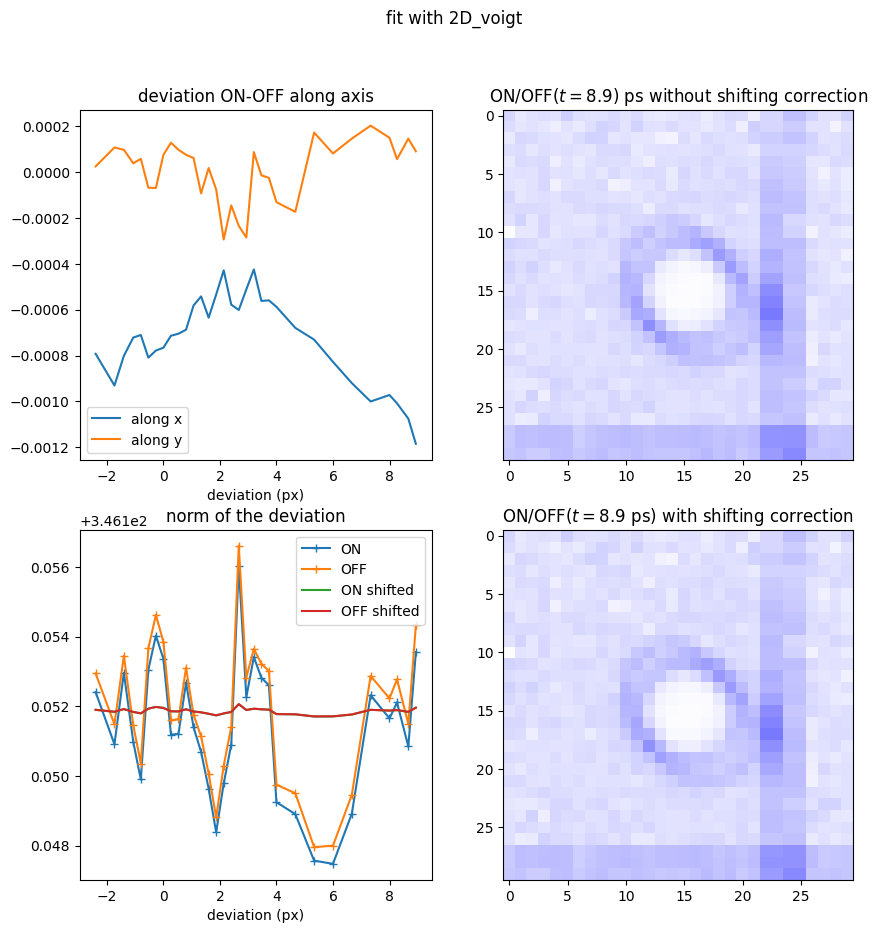

In [6]:
center0_on = []
center0_off = []
method='2D_voigt'
s_roi=15
ROI = [Zorder_in[1]-s_roi, Zorder_in[1]+s_roi, Zorder_in[0]-s_roi, Zorder_in[0]+s_roi]
for i in range(len(delay)):
    center0_on.append(find_peak.get_pos(imgON[i], ROI, method))
    center0_off.append(find_peak.get_pos(imgOFF[i], ROI, method))
s=0.1
center0_on = np.array(center0_on)
center0_off = np.array(center0_off)

### use function shift_0order in functions_analysis 
### We first shift image ON 0th order beam position to the position of imageOFF
### Then we shift both imgON and imgOFF to a reference point 
imgON_shifted = fa.shift_0order_fit(imgON, imgOFF, Zorder_in, s_roi, method)

ref = find_peak.get_pos(np.sum(imgOFF, axis=0), ROI, method)
print('The reference point is :', ref)

imgON_shifted = fa.shift_to_ref(imgON_shifted, ref, Zorder_in, s_roi, method)
imgOFF_shifted = fa.shift_to_ref(imgOFF, ref, Zorder_in, s_roi, method)
print(np.shape(imgON_shifted))

center0_on_shifted = []
center0_off_shifted = []

for i in range(len(delay)):
    center0_on_shifted.append(find_peak.get_pos(imgON_shifted[i], ROI, method))
    center0_off_shifted.append(find_peak.get_pos(imgOFF_shifted[i], ROI, method))

center0_on_shifted = np.array(center0_on_shifted)
center0_off_shifted = np.array(center0_off_shifted)


print('for the fist delay, discrepancy between on and off is : ', center0_on[0,0]-center0_off[0,0])
print('Zero order before shifting : ', center0_on[0])
print('Zero order after shifting : ', center0_on_shifted[0])
ind = -1
fig, ax = plt.subplots(2,2, figsize=(10,10))
fig.suptitle('fit with ' + method)
ax[0][0].set_title('deviation ON-OFF along axis')
ax[0][0].plot(delay, center0_on[:,0]-center0_off[:,0], label='along x')
ax[0][0].plot(delay, center0_on[:,1]-center0_off[:,1], label='along y')
# ax[0][0].plot(delay, center0_on_shifted[:,0]-center0_off[:,0], label='along x shifted')
# ax[0][0].plot(delay, center0_on_shifted[:,1]-center0_off[:,1], label='along y shifted')
ax[0][0].legend()
ax[0][0].set_xlabel('time (ps)')
ax[0][0].set_xlabel('deviation (px)')
img = imgON[ind, Zorder_in[0]-s_roi:Zorder_in[0]+s_roi, Zorder_in[1]-s_roi:Zorder_in[1]+s_roi] / imgOFF[ind, Zorder_in[0]-s_roi:Zorder_in[0]+s_roi,Zorder_in[1]-s_roi: Zorder_in[1]+s_roi] 
ax[0][1].set_title(r'ON/OFF($t=%.1f$) ps without shifting correction'%delay[ind])
ax[0][1].imshow(img-1, cmap='bwr', vmin=-s, vmax=s)
# ax[0][1].imshow(imgON[-1, Zorder_in[0]-s_roi:Zorder_in[0]+s_roi, Zorder_in[1]-s_roi:Zorder_in[1]+s_roi], cmap='bwr', vmin=-s, vmax=1e6)

ax[1][0].set_title(r'norm of the deviation')
ax[1][0].plot(delay, np.linalg.norm(center0_on, axis=1), '+-', label='ON')
ax[1][0].plot(delay, np.linalg.norm(center0_off, axis=1), '+-', label='OFF')

ax[1][0].plot(delay, np.linalg.norm(center0_on_shifted, axis=1), label='ON shifted')
ax[1][0].plot(delay, np.linalg.norm(center0_off_shifted, axis=1), label='OFF shifted')
ax[1][0].set_xlabel('time (ps)')
ax[1][0].set_xlabel('deviation (px)')
ax[1][0].legend()
img_shift = imgON_shifted[ind, Zorder_in[0]-s_roi:Zorder_in[0]+s_roi, Zorder_in[1]-s_roi:Zorder_in[1]+s_roi] / imgOFF_shifted[ind, Zorder_in[0]-s_roi:Zorder_in[0]+s_roi,Zorder_in[1]-s_roi: Zorder_in[1]+s_roi]
ax[1][1].set_title(r'ON/OFF($t=%.1f$ ps) with shifting correction'%(delay[ind]))
ax[1][1].imshow(img_shift-1, cmap='bwr', vmin=-s, vmax=s)

plt.savefig(path+r'.\0order_shift.png', dpi=200)


imgON = imgON_shifted  
imgOFF = imgOFF_shifted 

Get the distance between peaks from the 1st order Bragg peak position from pseudo voigt fit done in find_peak 
OUTPUT : dist_1st, alpha_1st

In [7]:
BP = []
for i in range(6):
    BP.append(Zorder + fa.rotate_vector(vec_i, i*angle_sym))
BP = np.array(BP).astype(np.int32)
print(BP)
BP_updated = []
for j, bp in enumerate(BP):
    pos = []
    for k in range(np.shape(imgON)[0]):
        # pos.append(find_peak.get_all(imgON[k], [bp[1]-s_roi, bp[1]+s_roi, bp[0]-s_roi, bp[0]+s_roi], path+'\\fit_peak'+ '\%i%i'%(j,k))[4:6])
        # pos.append(find_peak.get_all(imgON[k], [bp[1]-s_roi, bp[1]+s_roi, bp[0]-s_roi, bp[0]+s_roi])[4:6])
        pos.append(find_peak.get_pos_around(imgON[k], bp, s_roi, method='2D_voigt'))
    pos = np.reshape(np.mean(np.array(pos), axis=0), (2,))
    BP_updated.append(pos)
print(BP_updated)
vec = [] 
dist = []
for bp in BP_updated:
    vec.append(Zorder-bp)
    dist.append(np.linalg.norm(Zorder-bp))
# dist is the distance between peaks
    
print('pixel distance between peaks : ', dist)
print('vector between peaks : ', vec)
dist_1st = np.mean(np.array(dist))
vec_1st = np.mean(np.array(vec), axis=0)
print('mean pixel distance between peaks : ', dist_1st)
print('sum vector 0th order - Bragg peaks : ', vec_1st)


vert = np.array([0,1])
theta = np.arccos(np.dot(-vec[0], vert)/np.linalg.norm(vec[0]))
theta2 = np.arccos(np.dot(-vec[3], vert)/np.linalg.norm(vec[3]))
alpha_1st = theta*180/np.pi-90
alpha_1st2 = 90-theta2*180/np.pi
alpha=(alpha_1st+alpha_1st2)/2
print('angle of rotation from vertical : ', alpha)


[[337 260]
 [278 336]
 [183 323]
 [147 234]
 [206 158]
 [301 171]]
[array([336.46606084, 259.95007029]), array([277.39460761, 334.43455921]), array([183.85938506, 321.39181375]), array([148.61983572, 234.57353984]), array([206.83739205, 159.89999405]), array([301.24856638, 172.76990433])]
pixel distance between peaks :  [95.13049033839742, 93.95549951119666, 94.26627955595963, 94.42221053100653, 94.3013335404148, 95.12425021338326]
vector between peaks :  [array([-94.28959362, -12.62072606]), array([-35.2181404 , -87.10521497]), array([ 58.31708215, -74.06246951]), array([93.55663149, 12.7558044 ]), array([35.33907517, 87.42935019]), array([-59.07209916,  74.55943991])]
mean pixel distance between peaks :  94.53334394839305
sum vector 0th order - Bragg peaks :  [-0.22784073  0.15936399]
angle of rotation from vertical :  -7.693889053635317


Get the distance between peaks from the 2nd order Bragg peak position from pseudo voigt fit done in find_peak 
OUTPUT : dist_2nd, alpha_2nd

In [8]:
# second order 
BP = []
for i in range(6):
    BP.append(Zorder + fa.rotate_vector(2*vec_i, i*angle_sym))
BP = np.array(BP).astype(np.int32)
print(BP)
BP_updated= []
for j, bp in enumerate(BP):
    pos = []
    for k in range(np.shape(imgON)[0]):
        # pos.append(find_peak.get_all(imgON[k], [bp[1]-s_roi, bp[1]+s_roi, bp[0]-s_roi, bp[0]+s_roi], path+'\\fit_peak'+ '\%i%i'%(j,k))[4:6])
        # pos.append(find_peak.get_all(imgON[k], [bp[1]-s_roi, bp[1]+s_roi, bp[0]-s_roi, bp[0]+s_roi])[4:6])
        pos.append(find_peak.get_pos_around(imgON[k], bp, s_roi, method='2D_voigt'))

    pos = np.reshape(np.mean(np.array(pos), axis=0), (2,))
    BP_updated.append(pos)
print(BP_updated)
vec = [] 
dist = []
for bp in BP_updated:
    vec.append(Zorder-bp)
    dist.append(np.linalg.norm(Zorder-bp)/2)
# dist is the distance between peaks
    
print('pixel distance between peaks : ', dist)
print('vector between peaks : ', vec)
dist_2nd = np.mean(np.array(dist))
vec_2nd = np.mean(np.array(vec), axis=0)
print('mean pixel distance between peaks : ', dist_2nd)
print('sum vector 0th order - Bragg peaks : ', vec_2nd)


vert = np.array([0,1])
theta = np.arccos(np.dot(-vec[0], vert)/np.linalg.norm(vec[0]))
theta2 = np.arccos(np.dot(-vec[3], vert)/np.linalg.norm(vec[3]))
alpha_2nd = theta*180/np.pi-90
alpha_2nd2 = 90-theta2*180/np.pi
alpha=(alpha_2nd+alpha_2nd2)/2
print('angle of rotation from vertical : ', alpha)

[[432 273]
 [314 425]
 [123 398]
 [ 51 220]
 [170  69]
 [360  95]]
[array([431.00027523, 272.09357988]), array([312.57068017, 421.49569953]), array([122.88764906, 397.2574332 ]), array([ 52.79956571, 221.89835628]), array([171.36608002,  72.78138277]), array([360.39460199,  97.3661668 ])]
pixel distance between peaks :  [95.2203993915716, 93.92718527564926, 95.79699107847104, 95.5384032337111, 94.18213974300211, 95.47837710237611]
vector between peaks :  [array([-188.82380802,  -24.76423565]), array([ -70.39421296, -174.1663553 ]), array([ 119.28881816, -149.92808897]), array([189.3769015 ,  25.43098795]), array([ 70.81038719, 174.54796147]), array([-118.21813477,  149.96317744])]
mean pixel distance between peaks :  95.02391597079686
sum vector 0th order - Bragg peaks :  [0.33999185 0.18057449]
angle of rotation from vertical :  -7.5600290900882


Average between output from the two above cells. compute the calibration constant based on L and theoretical value. OUTPUT : alpha, L, cal, middle

In [9]:
# Zorder=Zorder_b
alpha=(alpha_1st+alpha_2nd)/2
L = (dist_1st+dist_2nd)/2
print('mean distance between peaks : %.3f px'%L)
print('mean angle form vertical : %.3f deg'%alpha)

a = 2.46 
g_px = L
g_A = 4*np.pi/(np.sqrt(3)*a)
cal = g_A/g_px ## A-1/px

print('mean distance between the peaks: ', L)
print('calibration constant from graphite : ', cal)
print('reciprocal lattice constant from cal : ', L*cal)
middle = np.array([256, 256])

mean distance between peaks : 94.779 px
mean angle form vertical : -7.548 deg
mean distance between the peaks:  94.77862995959495
calibration constant from graphite :  0.03111742868803578
reciprocal lattice constant from cal :  2.9492672589174274


Rotation of the 0th order and the images. OUTPUT: img_ON_rotated, img_OFF_rotated, Zorder_rot

In [18]:
# alpha=-alpha
alpha_rad = alpha*np.pi/180
print(Zorder)
print((Zorder-middle))
print(fa.rotate_vector((Zorder-middle), alpha_rad))
Zorder_rot = fa.rotate_vector((Zorder-middle), alpha_rad) + middle
print(Zorder_rot)
img_ON_rotated = [] 
img_OFF_rotated = []

for j in range(n_delay):
    img_ON_rotated.append(imutils.rotate_bound(imgON[j], angle=alpha))
    img_OFF_rotated.append(imutils.rotate_bound(imgOFF[j], angle=alpha))

img_ON_rotated = np.array(img_ON_rotated)
img_OFF_rotated = np.array(img_OFF_rotated)

[242.17646721 247.32934423]
[-13.82353279  -8.67065577]
[-14.8426713   -6.77978161]
[241.1573287  249.22021839]


In [21]:
print(np.shape(img_OFF_rotated))

(32, 574, 574)


Make the 0th order, the center of the images by cropping the rotated images. OUTPUT:  imgON_cut, imgOFF_cut, Zorder_cut

In [19]:
print(np.shape(img_ON_rotated))

print(Zorder_rot)
a = Zorder_rot[0]
b = Zorder_rot[1]
m = 512/2
if a < m:
    a_i = 0 
    a_f = round(2*a)
else:
    a_i = round(a-m)
    a_f = round(2*m)
if b < m:
    b_i = 0 
    b_f = round(2*b)
else:
    b_i = round(b-m)
    b_f = round(2*m)
print(a_i, a_f, b_i, b_f)
imgON_cut = img_ON_rotated[:, a_i:a_f, b_i:b_f]
imgOFF_cut = img_OFF_rotated[:, a_i:a_f, b_i:b_f]


## Zorder pos in cut images
m = round(np.shape(imgON_cut)[1]/2)
s_roi = 20
# Zorder_fit = find_peak.get_all(imgON_cut[0], [m-s_roi, m+s_roi, m-s_roi, m+s_roi])[4:6]
Zorder_fit = find_peak.get_pos_around(imgON_cut[0],np.array([m,m]), s_roi, method='2D_voigt')

Zorder_cut = np.reshape(Zorder_fit, (2,))
print(2*Zorder_cut)

(32, 574, 574)
[241.1573287  249.22021839]
0 482 0 498
[519.9999999  519.99999995]


Do the average between the symmetry axis. OUTPUT: imgON_rot_avg, imgOFF_rot_avg

In [20]:
print('shape of cut image: ', np.shape(imgOFF_cut))
imgON_rot_avg=[]
imgOFF_rot_avg=[]
for j in range(n_delay):
    imi_ON = [] 
    imi_OFF = []
    for i in range(6):
        imi_ON.append(imutils.rotate_bound(imgON_cut[j], angle=180*i/3))
        imi_OFF.append(imutils.rotate_bound(imgOFF_cut[j], angle=180*i/3))
    imgON_rot_avg.append(np.nanmean(np.array(imi_ON), axis=0))
    imgOFF_rot_avg.append(np.nanmean(np.array(imi_OFF), axis=0))

imgON_rot_avg = np.array(imgON_rot_avg)
imgOFF_rot_avg = np.array(imgOFF_rot_avg)
print('shpae of average between rotated image:', np.shape(imgOFF_rot_avg))


shape of cut image:  (32, 482, 498)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.

In [17]:
# print(np.where(imgON_fliped<1))
nan_mask = np.isnan(imgON_rot_avg)
print(nan_mask)
# imgON_try = imgON_rot_avg
# imgON_try[nan_mask] = imgOFF_rot_avg[nan_mask]

[[[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]]

 ...

 [[False False False ... False False False]
  [False False False ... False False False]
  [False False False ... False False False]
  ...
  [False False False ... False False Fal

In [14]:
## filter the image

imgON_fliped = filters.gaussian(img_as_float(imgON_rot_avg), sigma=1)
imgOFF_fliped = filters.gaussian(img_as_float(imgOFF_rot_avg), sigma=1)

# np.save(path + r'\data\imgON.npy', imgON_fliped)
# np.save(path + r'\data\delay.npy', delay)
# np.save(path + r'\data\imgOFF.npy', imgOFF_fliped)
# df = pd.DataFrame()
# df['imgON'] = list(imgON_rot_avg)
# df['imgOFF'] = list(imgOFF_rot_avg)
# df['delay'] = delay
# df.attrs['t0_index'] = t0_num
# df.attrs['calibration'] = cal
# df.attrs['peak_dist'] = L
# df.attrs['scan_number'] = scan_number
# df.attrs['Zorder_pos'] = Zorder_cut

# df.to_pickle(path + r'\data\PROC_'+scan_number, compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

In [ ]:
print(np.where(imgON_fliped<1))
mask = imgON_fliped > 1
imgON_try = imgON_fliped[mask]

In [ ]:
print(np.where(imgOFF_fliped<1))
mask = imgOFF_fliped > 1
print(mask)
print(np.shape(mask))
imgOFF_try = np.zeros_like(imgOFF_fliped)
print(np.shape(imgOFF_try))

imgOFF_try = imgOFF_fliped[mask]

In [ ]:
print(np.shape(imgOFF_try))

C:\Users\rclaude\AppData\Local\Temp\ipykernel_22852\2646515770.py:3: RuntimeWarning: invalid value encountered in divide
  img = (np.mean(imgON_fliped[at:], axis=0))/np.mean(imgOFF_fliped[at:], axis=0) - (np.mean(imgON_fliped[:bt], axis=0))/np.mean(imgOFF_fliped[:bt], axis=0)
C:\Users\rclaude\AppData\Local\Temp\ipykernel_22852\2646515770.py:4: RuntimeWarning: invalid value encountered in divide
  img = (np.nanmean(imgON_rot_avg[at:], axis=0))/np.nanmean(imgOFF_rot_avg[at:], axis=0) - (np.nanmean(imgON_rot_avg[:bt], axis=0))/np.nanmean(imgOFF_rot_avg[:bt], axis=0)


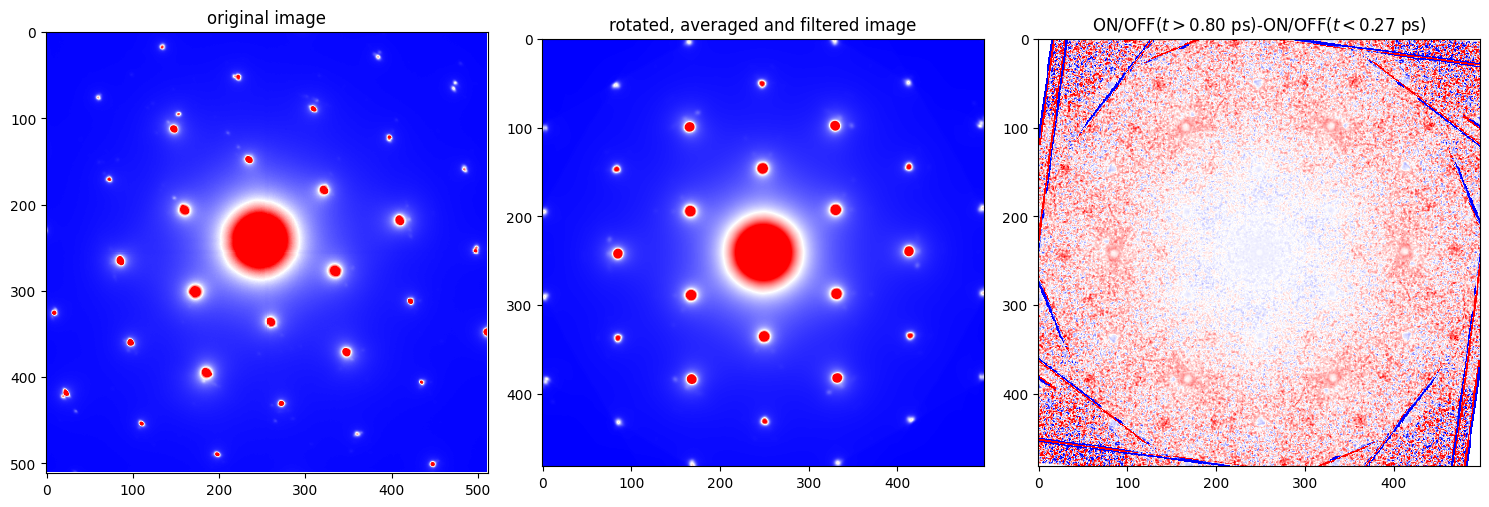

In [16]:
at = 10
bt = t0_num
img = (np.mean(imgON_fliped[at:], axis=0))/np.mean(imgOFF_fliped[at:], axis=0) - (np.mean(imgON_fliped[:bt], axis=0))/np.mean(imgOFF_fliped[:bt], axis=0)
img = (np.nanmean(imgON_rot_avg[at:], axis=0))/np.nanmean(imgOFF_rot_avg[at:], axis=0) - (np.nanmean(imgON_rot_avg[:bt], axis=0))/np.nanmean(imgOFF_rot_avg[:bt], axis=0)

# img=np.zeros_like(imgON)
# img = (np.mean(imgON_try[at:], axis=0))/np.mean(imgOFF_try[at:], axis=0) - (np.mean(imgON_try[:bt], axis=0))/np.mean(imgOFF_try[:bt], axis=0)
                                             
%matplotlib inline
sens=0.01
sens2 = 1e5
fig, axis = plt.subplots(1, 3, figsize=(15, 6),layout='tight')

axis[0].imshow(np.mean(imgOFF_shifted[at:], axis=0), cmap='bwr',vmin=0, vmax=sens2, aspect=1)
axis[0].set_title('original image')
im0 = axis[1].imshow(np.mean(imgON_fliped[at:], axis=0), cmap='bwr',vmin=0, vmax=sens2, aspect=1)
axis[1].set_title('rotated, averaged and filtered image')
# im0 = axis[0].imshow(img_ON_rotated[0], cmap='bwr',vmin=0, vmax=sens2, aspect=1)

axis[2].set_title('ON/OFF($t>$%.2f ps)-ON/OFF($t<$%.2f ps)'%(delay[at], delay[bt]))
axis[2].imshow(img, cmap='bwr',vmin=-sens, vmax=sens, aspect=1)

In [ ]:
cc =  L * np.sqrt(3)/3 *np.exp(1j * np.pi  * ( 1./3 * np.arange(7))) ## for hexagonal BZ
print(Zorder_cut)
BP_BZ = []
for i in range(6):
    BP_BZ.append([L*np.cos(np.pi*i/3), L*np.sin(np.pi*i/3)])

for i in range(6):
    BP_BZ.append([2*L*np.cos(np.pi*i/3), 2*L*np.sin(np.pi*i/3)])

for i in range(6):
    BP_BZ.append([np.sqrt(3)*L*np.cos(np.pi*i/3+np.pi/6), np.sqrt(3)*L*np.sin(np.pi*i/3+np.pi/6)])


BP_roi = [Zorder_cut + np.array(BP_BZ)]
BP_roi = BP_roi[0]
# print(BP_roi)

In [ ]:
at = 10
bt = t0_num
img = (np.mean(imgON_fliped[at:], axis=0))/np.mean(imgOFF_fliped[at:], axis=0) - (np.mean(imgON_fliped[:bt], axis=0))/np.mean(imgOFF_fliped[:bt], axis=0)

sens=0.008
sens2 = 3e5
fig, axis = plt.subplots(1, 3, figsize=(15, 6),layout='tight')
divider1 = make_axes_locatable(axis[0])
cax1 = divider1.append_axes('left', size='5%', pad=0.6)

im0 = axis[0].imshow(imgON[0], cmap='bwr',vmin=0, vmax=sens2, aspect=1)
fig.colorbar(im0, cax=cax1, shrink=0.6, orientation='vertical', label = 'electron count', format=ticker.FuncFormatter(fa.fmt), location='left')
axis[0].set_title('original image')

s1 = np.shape(imgON_fliped)[1]
s2 = np.shape(imgON_fliped)[2]
im1 = axis[1].imshow(imgON_fliped[0], extent =(cal*(Zorder_cut[1]), cal*(Zorder_cut[1]-s2), cal*(Zorder_cut[0]-s1), cal*(Zorder_cut[0])), cmap='bwr',vmin=0, vmax=sens2, aspect=1)
axis[1].set_xlabel(r'$k_x$ (\AA$^{-1}$)', labelpad=0.5)
axis[1].set_ylabel(r'$k_y$ (\AA$^{-1}$)', labelpad=-5)
axis[1].set_title('Averaged with symmetry and calibrated')

for i in range(len(BP_roi)):
        axis[1].add_patch(Polygon(cal*np.c_[(cc.real+Zorder_cut[1]-BP_roi[i][1]), (cc.imag+Zorder_cut[0]-BP_roi[i][0])],
             lw=0.5, edgecolor='k',
             clip_on=False, facecolor='none'))
        axis[1].add_patch(Circle((cal*(Zorder_cut[1]-BP_roi[i][1]), cal*(Zorder_cut[0]-BP_roi[i][0])), 0.1, fill = False, edgecolor = 'k', lw = 1))
        

divider2 = make_axes_locatable(axis[2])
cax2 = divider2.append_axes('right', size='5%', pad=0.6)
axis[2].set_title(r'ON/OFF($t>$%.2f ps)-ON/OFF($t<$%.2f ps)'%(delay[at], delay[bt]))
im2 = axis[2].imshow(1e2*img, extent =(cal*(Zorder_cut[1]), cal*(Zorder_cut[1]-s2), cal*(Zorder_cut[0]-s1), cal*(Zorder_cut[0])), cmap='bwr',vmin=-1e2*sens, vmax=1e2*sens, aspect=1)
fig.colorbar(im2, cax=cax2, shrink=0.6, orientation='vertical', label = r'electron count variation ($\%$)', format='%.1f', location='right')
axis[2].set_xlabel(r'$k_x$ (\AA$^{-1}$)', labelpad=0.5)
axis[2].set_ylabel(r'$k_y$ (\AA$^{-1}$)', labelpad=-5)
for i in range(len(BP_roi)):
        axis[2].add_patch(Polygon(cal*np.c_[(cc.real+Zorder_cut[1]-BP_roi[i][1]), (cc.imag+Zorder_cut[0]-BP_roi[i][0])],
             lw=0.5, edgecolor='k',
             clip_on=False, facecolor='none'))
        axis[2].add_patch(Circle((cal*(Zorder_cut[1]-BP_roi[i][1]), cal*(Zorder_cut[0]-BP_roi[i][0])), 0.1, fill = False, edgecolor = 'k', lw = 0.5))

plt.savefig(path+r'\overall_processed.png', format='png', dpi=300)

In [ ]:
at = 10
bt = t0_num-1
%matplotlib inline
# img_filtered = (np.mean(imgON_fliped[:bt], axis=0))/np.mean(imgON_fliped[:bt]) - (np.mean(imgOFF_fliped[:bt], axis=0))/np.mean(imgOFF_fliped[:bt])
# img_averaged = (np.mean(imgON_rot_avg[:bt], axis=0))/np.mean(imgON_rot_avg[:bt]) - (np.mean(imgOFF_rot_avg[:bt], axis=0))/np.mean(imgOFF_rot_avg[:bt])
# img_tilt = (np.mean(imgON_cut[:bt], axis=0))/np.mean(imgON_cut[:bt]) - (np.mean(imgOFF_cut[:bt], axis=0))/np.mean(imgOFF_cut[:bt])
imgON_all = [imgON_cut, imgON_rot_avg, imgON_fliped]
imgOFF_all = [imgOFF_cut, imgOFF_rot_avg, imgOFF_fliped]

img = []
for i, imgON_i in enumerate(imgON_all):
    #### effect of the laser before t0
    # img.append((np.mean(imgON_i[:bt], axis=0))/np.mean(imgON_i[:bt]) - (np.mean(imgOFF_all[i][:bt], axis=0))/np.mean(imgOFF_all[i][:bt]))
    #### without OFF images
    # img.append((np.mean(imgON_i[at:], axis=0))/np.mean(imgON_i[at:]) - (np.mean(imgON_i[:bt], axis=0))/np.mean(imgON_i[:bt]))
    #### with ON-OFF substraction
    # img.append((np.mean(imgON_i[at:], axis=0))/np.mean(imgON_i[at:]) - (np.mean(imgOFF_all[i][at:], axis=0))/np.mean(imgOFF_all[i][at:]))
    #### with ON-OFF substracting by before t0
    # img.append((np.mean(imgON_i[at:], axis=0))/np.mean(imgON_i[at:]) - (np.mean(imgOFF_all[i][at:], axis=0))/np.mean(imgOFF_all[i][at:])
    #             - ((np.mean(imgON_i[:bt], axis=0))/np.mean(imgON_i[:bt]) - (np.mean(imgOFF_all[i][:bt], axis=0))/np.mean(imgOFF_all[i][:bt])))
    #### division ON/OFF
    img.append((np.mean(imgON_i[at:], axis=0))/np.mean(imgOFF_all[i][at:], axis=0) - (np.mean(imgON_i[:bt], axis=0)/np.mean(imgOFF_all[i][:bt], axis=0)))
    #### division ON/OFF without before t0 substraction 
    # img.append((np.mean(imgON_i[at:], axis=0))/np.mean(imgOFF_all[i][at:], axis=0) - 1)
    # img.append((np.mean(imgON_i[:bt], axis=0))/np.mean(imgOFF_all[i][:bt], axis=0) - 1)
    #### division ON/ON(bt)
    # img.append((np.mean(imgON_i[at:], axis=0)-np.mean(imgON_i[:bt], axis=0))/np.mean(imgON_i[:bt], axis=0))    





sens=0.15
sens2 = 1e5
fig, axis = plt.subplots(1, 3, figsize=(15, 6),layout='tight')
plt.title('ON/OFF($t>$%.2f ps)-ON/OFF($t<$%.2f ps)'%(delay[at], delay[bt]))

axis[0].set_title('only tilted')
axis[0].imshow(img[0], cmap='bwr',vmin=-sens, vmax=sens, aspect=1)

axis[1].set_title('6 fold symmetry')
axis[1].imshow(img[1], cmap='bwr',vmin=-sens, vmax=sens, aspect=1)

axis[2].set_title('6-fold symmetry + filter')
axis[2].imshow(img[2], cmap='bwr',vmin=-sens, vmax=sens, aspect=1)

In [ ]:
print(Zorder)

In [ ]:
### Zero order inspection 
r_BP = 15
posZ=[]
heightZ=[]
sigZ=[]
for o in range(len(delay)):
    # print(BP_pos[0][i])
    res = (fa.fit_BP(imgON[o], Zorder, r_BP))
    posZ.append(res[0])
    heightZ.append(res[1])
    sigZ.append(res[2])

posZ=np.array(posZ)
heightZ=np.array(heightZ)
sigZ=np.array(sigZ)

In [ ]:
fig, axis = plt.subplots(1,3, figsize=(18, 6),layout='tight')

axis[0].plot(delay, posZ[:,0]-posZ[0,0], '*-', label=r'kx')
axis[0].plot(delay, posZ[:,1]-posZ[0,1], '*-', label=r'ky')
axis[0].legend(loc='lower right')
axis[0].set_xlabel('delay (ps)', fontsize=16)
axis[0].set_ylabel(r'position variation (px)', fontsize=16)
axis[0].set_title(scan_number+'Zorder')


axis[1].plot(delay, heightZ[:,0]-heightZ[0,0], '*-', label=r'kx')
axis[1].plot(delay, heightZ[:,1]-heightZ[0,1], '*-', label=r'ky')
axis[1].legend(loc='lower right')
axis[1].set_xlabel('delay (ps)', fontsize=16)
axis[1].set_ylabel(r'fit height variation ', fontsize=16)
axis[1].set_title(scan_number+' height')

axis[2].plot(delay, sigZ[:,0]-sigZ[0,0], '*-', label=r'kx')
axis[2].plot(delay, sigZ[:,1]-sigZ[0,1], '*-', label=r'ky')
axis[2].legend(loc='lower right')
axis[2].set_xlabel('delay (ps)', fontsize=16)
axis[2].set_ylabel(r'FHWM variation (px)', fontsize=16)
axis[2].set_title(scan_number+'FHWM')
